In [1]:
import numpy as np 
import tensorflow as tf
print(tf.__version__)
import sciann as sn 
import time
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from itertools import product, combinations
import scipy.io
import os
import skimage as ski
tf.test.gpu_device_name()
%matplotlib inline

2024-07-15 11:09:56.688100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:09:56.821351: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 11:09:56.853023: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 11:09:57.325867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

2.10.1
---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.1 
Python Version: 3.8.16 (default, Jun 12 2023, 18:09:05) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


2024-07-15 11:09:59.950509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:10:00.601610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 45708 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [2]:

np.random.seed(123)
tf.random.set_seed(123)

#Model specifications

# Computational model parameters

vp = np.load('./mar_vp.npy')
vs = np.load('./mar_vs.npy')

vp = vp[10:,:]
vs = vs[10:,:]

sigma = 1
vp = ski.filters.gaussian(vp, sigma)
vs = ski.filters.gaussian(vs, sigma)

nz, nx = vp.shape[0], vp.shape[1]

zmin = 0.; dz = 0.025; zmax = (nz-1)*dz;
xmin = 0.; dx = 0.025; xmax = (nx-1)*dx;

# Point-source locations
ns = 20
sz = 0.
ds = 0.5
sx = np.round(np.arange(0.25, (ns+1)*0.5,ds),2);

vp_true = vp
vs_true = vs

In [3]:
# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)

z = np.arange(zmin,zmax+dz,dz)
x = np.arange(xmin,xmax+dx,dx)

Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

# Extending the velocity model in thirs dimension byy repeatin the array
velpmodel = np.repeat(vp[...,np.newaxis], ns, axis=2)
velsmodel = np.repeat(vs[...,np.newaxis], ns, axis=2)

velpmodel = velpmodel + np.random.uniform(-1,1,size=(velpmodel.shape[0],velpmodel.shape[1],velpmodel.shape[2]))*0.2
velsmodel = velsmodel + np.random.uniform(-1,1,size=(velsmodel.shape[0],velsmodel.shape[1],velsmodel.shape[2]))*0.1

X_star = [Z.reshape(-1,1), X.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction


In [4]:
print(vp_true.max(),vp_true.max())
print(vs_true.max(),vs_true.min())
print("taup1 range:",vp_true[0,:].min()/vp_true[0,:].max(),vp_true[0,:].max()/vp_true[0,:].min())
print("taus1 range:",vs_true[0,:].min()/vs_true[0,:].max(),vs_true[0,:].max()/vs_true[0,:].min())

4.663199417387084 4.663199417387084
2.2400918946538524 0.7651286132234595
taup1 range: 0.7530054035753992 1.3280117184442872
taus1 range: 0.7530054032605211 1.3280117189996112


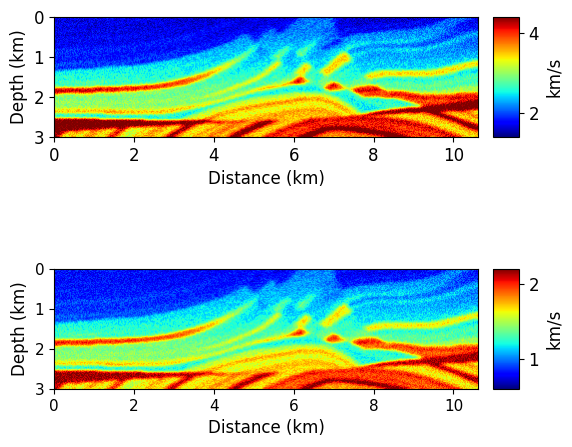

In [5]:
# Plot the velocity model with the source location
font_size = 12
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
ax = plt.gca()
im = ax.imshow(velpmodel[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=font_size)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=font_size)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.4,4.4)

cbar.set_label('km/s',size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.subplot(2,1,2)
ax = plt.gca()
im = ax.imshow(velsmodel[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(0.6,2.2)

cbar.set_label('km/s',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

#plt.savefig("./Fig/v_mar_true.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

In [6]:
# Load traveltime solution
Tp_data = np.load('./Tp_data_mar_vsp_small.npy')
Ts_data = np.load('./Ts_data_mar_vsp_small.npy')

Tp_data_noi = Tp_data + np.random.randn(Tp_data.shape[0],Tp_data.shape[1],Tp_data.shape[2])*Tp_data.max()*0.0
Ts_data_noi = Ts_data + np.random.randn(Ts_data.shape[0],Ts_data.shape[1],Ts_data.shape[2])*Ts_data.max()*0.0
print(Tp_data.shape)

(121, 426, 21)


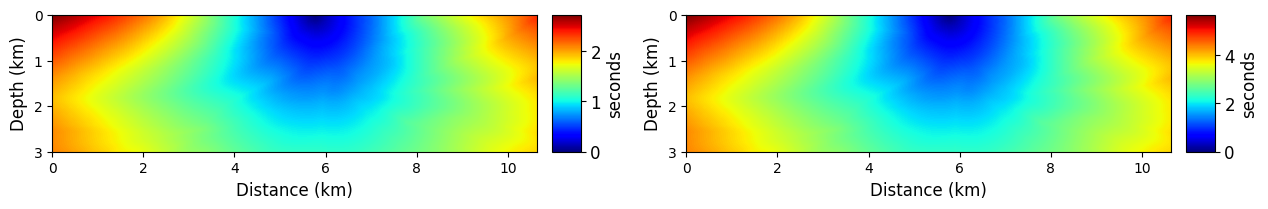

In [7]:
# Plot the PINN solution error
isou = 11

plt.style.use('default')

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(Tp_data[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(Ts_data[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

#plt.savefig("./Fig/Tp_Ts_pred_tomodd.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

In [8]:
##Receiver locations
iz1 = np.round(np.arange(0,zmax+dz,dz),2)
ix1 = 0.0
iZ1,iX1,iSX1 = np.meshgrid(iz1,ix1,sx,indexing='ij')
ss1 = [iZ1.reshape(-1,1),iX1.reshape(-1,1),iSX1.reshape(-1,1)]

iz2 = np.round(np.arange(0,zmax+dz,dz),2)
ix2 = xmax
iZ2,iX2,iSX2 = np.meshgrid(iz2,ix2,sx,indexing='ij')
ss2 = [iZ2.reshape(-1,1),iX2.reshape(-1,1),iSX2.reshape(-1,1)]

In [9]:
num = 200000

rz = np.round(np.random.uniform(zmin, zmax, num), 4).reshape(-1,1)
rx = np.round(np.random.uniform(xmin, xmax, num), 4).reshape(-1,1)
rsx = np.round(np.random.uniform(zmin, zmax, num), 4).reshape(-1,1)

rz = np.append(rz,ss1[0])
rx = np.append(rx,ss1[1]) 
rsx = np.append(rsx, ss1[2])

rz = np.append(rz,ss2[0])
rx = np.append(rx,ss2[1]) 
rsx = np.append(rsx, ss2[2])

rsz = np.zeros(rsx.shape)

In [10]:
rz_new = (rsz / dz).astype(int)
rx_new = (rsx / dx).astype(int)

rvelp_list = []
rvels_list = []

for rz_, rx_  in zip(rz_new, rx_new):
    rvelp_list.append(velpmodel[:,:,0][rz_,rx_])
    rvels_list.append(velsmodel[:,:,0][rz_,rx_])
rvelp = np.array(rvelp_list)
rvels = np.array(rvels_list)

In [11]:
T0p = np.sqrt((rz-rsz)**2 + (rx-rsx)**2)/rvelp; 
px0p = np.divide(rx-rsx, T0p*rvelp**2, out=np.zeros_like(T0p),where=T0p!=0)
pz0p = np.divide(rz-rsz, T0p*rvelp**2, out=np.zeros_like(T0p),where=T0p!=0)

T0s = np.sqrt((rz-rsz)**2 + (rx-rsx)**2)/rvels; 
px0s = np.divide(rx-rsx, T0s*rvels**2, out=np.zeros_like(T0s),where=T0s!=0)
pz0s = np.divide(rz-rsz, T0s*rvels**2, out=np.zeros_like(T0s),where=T0s!=0)

In [12]:
indices = np.arange(len(rx) - ss1[1].size - ss2[1].size, len(rx))
index = np.where(np.isin(np.arange(len(rx)), indices))[0]
print(index)

[200000 200001 200002 ... 205079 205080 205081]


In [13]:
z_n1 = ((ss1[0] / dz) + 1e-9).astype(int)
x_n1 = ((ss1[1] / dx) + 1e-9).astype(int)
sx_n1 = ((ss1[2] / ds) + 1e-9).astype(int)

z_n2 = ((ss2[0] / dz) + 1e-9).astype(int)
x_n2 = ((ss2[1] / dx) + 1e-9).astype(int)
sx_n2 = ((ss2[2] / ds) + 1e-9).astype(int)

In [14]:
print(z_n1.shape)
print(x_n1.shape)
print(sx_n1.shape)
print(Tp_data.shape)
print(Ts_data.shape)

(2541, 1)
(2541, 1)
(2541, 1)
(121, 426, 21)
(121, 426, 21)


In [15]:
Tp_list = []
Ts_list = []
for rz_, rx_,rsx_ in zip(z_n1, x_n1, sx_n1):
    Tp_list.append(Tp_data[rz_, rx_,rsx_])
    Ts_list.append(Ts_data[rz_, rx_,rsx_])

for rz_, rx_,rsx_ in zip(z_n2, x_n2, sx_n2):
    Tp_list.append(Tp_data[rz_, rx_,rsx_])
    Ts_list.append(Ts_data[rz_, rx_,rsx_])
    
Tp = np.array(Tp_list)
Ts = np.array(Ts_list)

In [16]:
from sciann.utils.math import *
hidden_layers = 8*[64]
hidden_layers2 = 8*[32]
dtype = 'float32'

xt = sn.Variable("xt", dtype=dtype)
zt = sn.Variable("zt", dtype=dtype)
sxt = sn.Variable("sxt", dtype=dtype)

Tp0_xt = sn.Variable("Tp0_xt",dtype=dtype)
Tp0_zt = sn.Variable("Tp0_zt",dtype=dtype)
Tp0t = sn.Variable("Tp0t",dtype=dtype)

Ts0_xt = sn.Variable("Ts0_xt",dtype=dtype)
Ts0_zt = sn.Variable("Ts0_zt",dtype=dtype)
Ts0t = sn.Variable("Ts0t",dtype=dtype)

In [17]:
taup, taus = sn.Functional(['taup','taus'], [xt, zt, sxt], hidden_layers, 'l-elu','sigmoid')
vp, vs = sn.Functional(['vp','vs'], [xt, zt], hidden_layers2, 'l-elu','sigmoid')
taup = taup*2.0
taus = taus*2.0
vp = vp*5.0
vs = vs*3.0

In [18]:
print(Tp.shape)
print(Ts.shape)
print(index)

(5082, 1)
(5082, 1)
[200000 200001 200002 ... 205079 205080 205081]


In [19]:
tau_dd = taup*Tp0t - taus*Ts0t
taup_x = sn.diff(taup, xt)
taup_z = sn.diff(taup, zt)

taus_x = sn.diff(taus, xt)
taus_z = sn.diff(taus, zt)

taup_d = sn.Data(taup*Tp0t)
taus_d = sn.Data(taus*Ts0t)
taups_dd = sn.Data(tau_dd)

vp_d = sn.Data(vp)
vs_d = sn.Data(vs)

# Loss function based on the factored isotropic eikonal equation
Lp = (Tp0t*taup_x + taup*Tp0_xt)**2 + (Tp0t*taup_z + taup*Tp0_zt)**2 - 1.0/vp**2
Ls = (Ts0t*taus_x + taus*Ts0_xt)**2 + (Ts0t*taus_z + taus*Ts0_zt)**2 - 1.0/vs**2

imposed_ids = index
imposed_taup = (Tp[index-num]).reshape(-1,1)
imposed_taus = (Ts[index-num]).reshape(-1,1)

targets = [taup_d, taus_d, Lp, Ls]
target_vals = [(imposed_ids, imposed_taup),(imposed_ids, imposed_taus),'zeros','zeros']

In [20]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[zt, xt, sxt, Tp0_zt, Tp0_xt, Tp0t, Ts0_zt, Ts0_xt, Ts0t],
    targets=targets,
    loss_func="mse"
)

In [21]:
training_data = [rz,rx,rsx,pz0p,px0p,T0p,pz0s,px0s,T0s]
batch_num = 100
epoch_num = 1000
start_time = time.time()
hist = model.train(
       training_data,
       target_vals,
       batch_size = rz.shape[0]//batch_num,#1024
       epochs = epoch_num,
       learning_rate = 0.001,
       verbose=2,
       #adaptive_weights=10
       )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))


Total samples: 205082 
Batch size: 2050 
Total batches: 101 



2024-07-15 11:10:02.867436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45708 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2024-07-15 11:10:02.902063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/1000


2024-07-15 11:10:07.257578: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 - 6s - loss: 1.1802 - mul_7_loss: 0.1652 - mul_8_loss: 0.8811 - sub_2_loss: 0.0049 - sub_3_loss: 0.1179 - lr: 0.0010 - time: 6.0313 - 6s/epoch - 60ms/step
Epoch 2/1000
101/101 - 3s - loss: 0.2388 - mul_7_loss: 0.0684 - mul_8_loss: 0.1503 - sub_2_loss: 0.0012 - sub_3_loss: 0.0168 - lr: 0.0010 - time: 2.7610 - 3s/epoch - 27ms/step
Epoch 3/1000
101/101 - 3s - loss: 0.2366 - mul_7_loss: 0.0659 - mul_8_loss: 0.1527 - sub_2_loss: 0.0010 - sub_3_loss: 0.0148 - lr: 0.0010 - time: 2.7429 - 3s/epoch - 27ms/step
Epoch 4/1000
101/101 - 3s - loss: 0.2448 - mul_7_loss: 0.0648 - mul_8_loss: 0.1611 - sub_2_loss: 0.0011 - sub_3_loss: 0.0169 - lr: 0.0010 - time: 2.7434 - 3s/epoch - 27ms/step
Epoch 5/1000
101/101 - 3s - loss: 0.2319 - mul_7_loss: 0.0643 - mul_8_loss: 0.1515 - sub_2_loss: 0.0010 - sub_3_loss: 0.0138 - lr: 0.0010 - time: 2.7687 - 3s/epoch - 27ms/step
Epoch 6/1000
101/101 - 3s - loss: 0.2397 - mul_7_loss: 0.0670 - mul_8_loss: 0.1585 - sub_2_loss: 9.8477e-04 - sub_3_loss: 0.0143 - lr

Text(0, 0.5, 'loss')

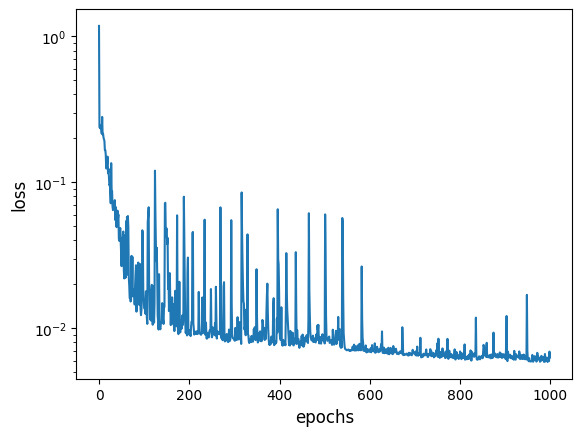

In [22]:
plt.semilogy(hist.history['loss'])
plt.xlabel('epochs', fontsize=font_size)
plt.ylabel('loss', fontsize=font_size)
#plt.savefig("./Fig/loss_adam_tomo_mar.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

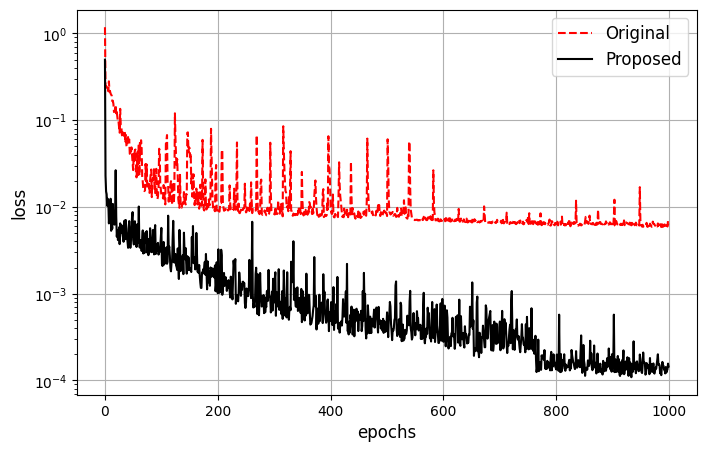

In [23]:
loss_tomo_ori = hist.history['loss']
np.save('./Fig/loss_tomo_mar_vsp_ori_noi%d.npy'%(epoch_num),loss_tomo_ori)

loss_tomo_new = np.load('./Fig/loss_tomo_mar_vsp_new%d.npy'%(epoch_num))
plt.style.use('default')

plt.figure(figsize=(8,5))

ax = plt.gca()
plt.semilogy(loss_tomo_ori[::1],'r--')
plt.semilogy(loss_tomo_new[::1],'k')
plt.xlabel('epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(['Original','Proposed'], fontsize=12)
plt.grid()
# plt.savefig("./Fig/loss_comp_mar_vsp_random_noi.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

In [24]:
vp_s = velpmodel[np.round(SZ/dz).astype(int),np.round(SX/dx).astype(int),0] # Velocity at the source location
vs_s = velsmodel[np.round(SZ/dz).astype(int),np.round(SX/dx).astype(int),0]

Tp0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vp_s;
Ts0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vs_s;

pxp0 = np.divide(X-SX, Tp0*vp_s**2, out=np.zeros_like(Tp0), where=Tp0!=0)
pzp0 = np.divide(Z-SZ, Tp0*vp_s**2, out=np.zeros_like(Tp0), where=Tp0!=0)

pxs0 = np.divide(X-SX, Ts0*vs_s**2, out=np.zeros_like(Ts0), where=Ts0!=0)
pzs0 = np.divide(Z-SZ, Ts0*vs_s**2, out=np.zeros_like(Ts0), where=Ts0!=0)

pxp0 = pxp0.reshape(-1,1)
pzp0 = pzp0.reshape(-1,1)
Tp0 = Tp0.reshape(-1,1)

pxs0 = pxs0.reshape(-1,1)
pzs0 = pzs0.reshape(-1,1)
Ts0 = Ts0.reshape(-1,1)

test_data = X_star + [pzp0,pxp0,Tp0] + [pzs0,pxs0,Ts0]

taup_pred = taup.eval(model, test_data)
Tp_pred = taup_pred*Tp0
taup_pred = taup_pred.reshape(Z.shape)
Tp_pred = Tp_pred.reshape(Z.shape)
np.save('./mar_pinntomo_taup_pred_random_ori_noi%d.npy'%(epoch_num),taup_pred)
np.save('./mar_pinntomo_Tppred_random_ori_noi%d.npy'%(epoch_num),Tp_pred)

taus_pred = taus.eval(model, test_data)
Ts_pred = taus_pred*Ts0
taus_pred = taus_pred.reshape(Z.shape)
Ts_pred = Ts_pred.reshape(Z.shape)
np.save('./mar_pinntomo_taus_pred_random_ori_noi%d.npy'%(epoch_num),taus_pred)
np.save('./mar_pinntomo_Tppred_random_ori_noi%d.npy'%(epoch_num),Tp_pred)

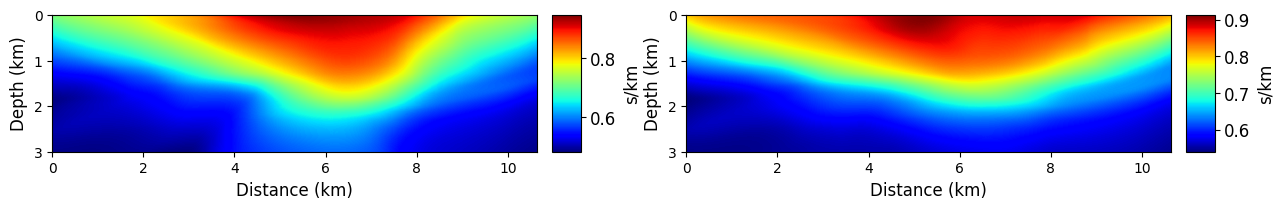

In [25]:
# Plot the PINN solution error
taup_pred3d = taup_pred.reshape(Z.shape)
taus_pred3d = taus_pred.reshape(Z.shape)
isou = 11

plt.style.use('default')

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(taup_pred3d[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('s/km',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(taus_pred3d[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('s/km',size=font_size)
cbar.ax.tick_params(labelsize=font_size)


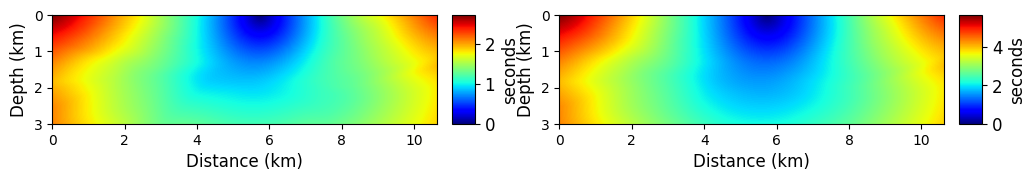

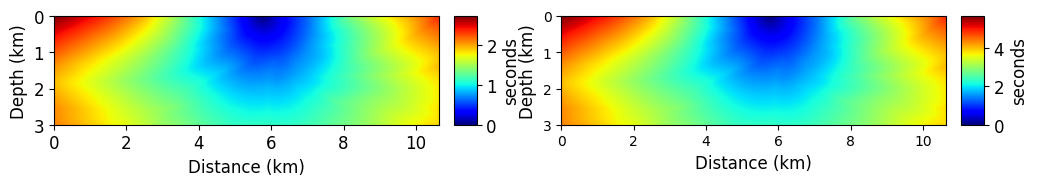

In [26]:
# Plot the PINN solution error
plt.style.use('default')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(Tp_pred[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(Ts_pred[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.style.use('default')
# plt.savefig("./Fig/Tp_Ts_pred_mar_sou11_tomo_vsp_new.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(Tp_data_noi.reshape(Z.shape)[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=font_size)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=font_size)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(Ts_data_noi.reshape(Z.shape)[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

#plt.savefig("./Fig/Tp_Ts_true_mar_sou10.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

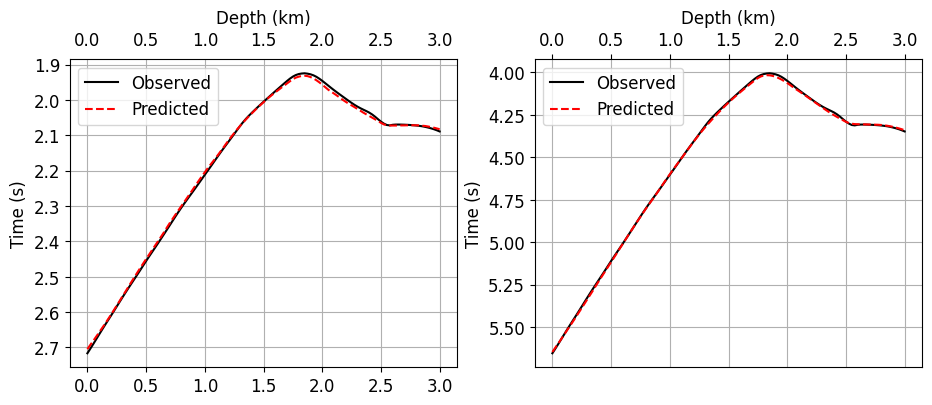

In [27]:
isou = 11

plt.style.use('default')

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
ax.xaxis.set_tick_params(labeltop='on')


plt.plot(z,Tp_data.reshape(Z.shape)[:,1,isou],'k-')
#plt.plot(Tp_data_noi.reshape(Z.shape)[:,-1,10],z,'b:')
plt.plot(z,Tp_pred.reshape(Z.shape)[:,1,isou],'r--')


ax.set_title('Depth (km)', fontsize=font_size)
plt.xticks(fontsize=font_size)

plt.ylabel('Time (s)', fontsize=font_size)
plt.yticks(fontsize=font_size)

#plt.ylim([0,1])
#plt.xlim([1.25,4.5])

plt.gca().invert_yaxis()

plt.legend(['Observed','Predicted'],fontsize=font_size)

plt.grid()

plt.subplot(1,2,2)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
ax.xaxis.set_tick_params(labeltop='on')


plt.plot(z,Ts_data.reshape(Z.shape)[:,1,isou],'k-')
#plt.plot(Ts_data_noi.reshape(Z.shape)[:,-1,10],z,'b:')
plt.plot(z,Ts_pred.reshape(Z.shape)[:,1,isou],'r--')

ax.set_title('Depth (km)', fontsize=font_size)
plt.xticks(fontsize=font_size)

plt.ylabel('Time (s)', fontsize=font_size)
plt.yticks(fontsize=font_size)

#plt.ylim([0,1])
#plt.xlim([1.25,4.5])

plt.gca().invert_yaxis()

plt.legend(['Observed','Predicted'],fontsize=font_size)

plt.grid()

# plt.savefig("./Fig/T_trace_mar_tomo_isou11_well1_new.jpeg", format='jpeg', bbox_inches="tight")

In [28]:
vp_pred = vp.eval(model, test_data)
vp_pred = vp_pred.reshape(Z.shape)

vs_pred = vs.eval(model, test_data)
vs_pred = vs_pred.reshape(Z.shape)

np.save('./vp_pred_mar_tomo_vsp_ori_noi.npy',vp_pred)
np.save('./vs_pred_mar_tomo_vsp_ori_noi.npy',vs_pred)

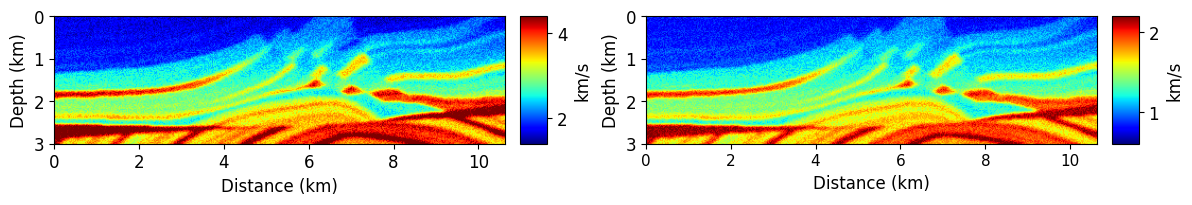

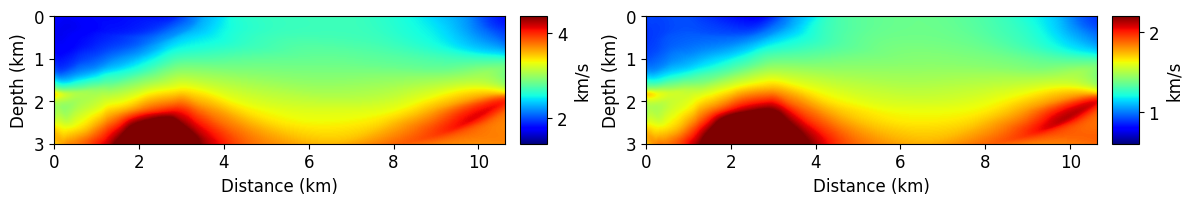

In [29]:
# Plot the velocity model with the source location
plt.style.use('default')

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(velpmodel[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=font_size)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=font_size)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.4,4.4)

cbar.set_label('km/s',size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(velsmodel[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=font_size)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(0.6,2.2)

cbar.set_label('km/s',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(vp_pred[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=font_size)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=font_size)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.4,4.4)

cbar.set_label('km/s',size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(vs_pred[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=font_size)
plt.xticks(fontsize=font_size)

plt.ylabel('Depth (km)', fontsize=font_size)
plt.yticks(fontsize=font_size)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(0.6,2.2)

cbar.set_label('km/s',size=font_size)
cbar.ax.tick_params(labelsize=font_size)

# plt.savefig("./Fig/mar_vp_vs_pred_tomo_vsp_ori_noi.jpeg", format='jpeg', bbox_inches="tight",dpi=400)